In [8]:
# qubit reset: Analysis of probability ['0'] vs number of resets:       
#This cell has function which can produce circuit of qubit reset, num_reset times
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister,transpile
from qiskit.circuit.classical import expr
def get_qubit_reset(num_resets):
    cr1=ClassicalRegister(1,name="cr1")     # for mid circuit measurement    
    qr=QuantumRegister(1,name="qr")
    qc=QuantumCircuit(qr,cr1)
    # initialization
    qc.h(0)    
    for i in range(num_resets):
        # mid Circuit Measurement
        qc.measure(qr[0],cr1[0])
        parity= expr.lift(cr1[0])
        #feed forward operation
        with qc.if_test(parity):
            qc.x(qr[0])
    qc.measure(qr[0],cr1[0])               # Final measurement
    return qc
            
        


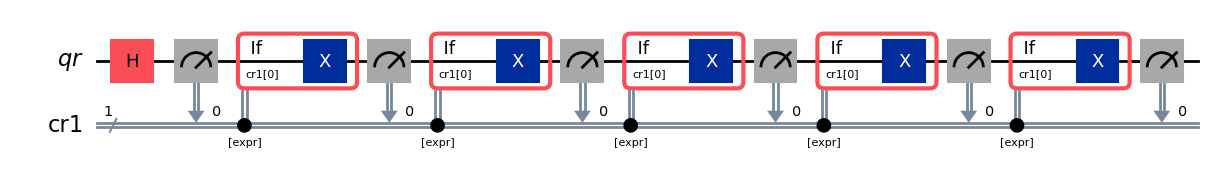

In [9]:
# This cell is for testing whether we succeded in previous cell
qc=get_qubit_reset(5)
qc.draw("mpl")

In [42]:
# trasnpilation
# Creating list of transpiled circuits having 1 no of resets to 10 no of resets (10 copies of each circuit)
from qiskit.providers.fake_provider import GenericBackendV2
backend = GenericBackendV2(num_qubits=2,control_flow=True,seed=13)     # fixed seed for reproducibility, num_qubits at least should be 2
max_num_reset=10
qc_transpiled_list=[]
num_reset_list=list(range(1,max_num_reset+1))
for num_reset in num_reset_list:
    for i in range(10):                     # for taking 10 copies of each circuit , needed for taking mean, standard deviation of the probability ['0']
        circuit=get_qubit_reset(num_reset)   # However, all 10 outputs will be same (seed is fixed)
        transpiled_circuit = transpile(circuit, backend)
        qc_transpiled_list.append(transpiled_circuit)

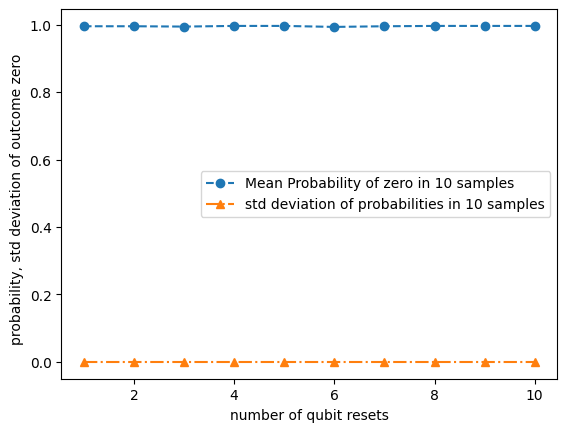

In [55]:
# Run the transpiled circuits using the simulated backend
import matplotlib.pyplot as plt
import statistics
job = backend.run(qc_transpiled_list)
result=job.result()
list_std_deviation_prob_zero=[]
list_mean_prob_zero=[]
list_probs=[]                             # we will fill here our probabilities of zero corresponding to number of qubit resets 
for i in range(0,len(num_reset_list)):
    for j in range(10):
        counts = result.results[i].data.counts           # not sure why i+1 perhaps data needed starts from 1 index
        #counts=data.cr1.get_counts()
        total_counts=result.results[i].shots
        prob_zero=(counts['0x0'])/total_counts
        list_probs.append(prob_zero)
    list_mean_prob_zero.append(statistics.mean(list_probs))
    list_std_deviation_prob_zero.append(statistics.stdev(list_probs))
    list_probs.clear()                                           # for next iteration use
plt.plot(num_reset_list,list_mean_prob_zero,'--o',label='Mean Probability of zero in 10 samples')
plt.plot(num_reset_list,list_std_deviation_prob_zero,'-.^',label='std deviation of probabilities in 10 samples')
plt.xlabel('number of qubit resets')
plt.ylabel('probability, std deviation of outcome zero  ')
plt.legend()

In [56]:
list_mean_prob_zero  # printing probability corresponding to different no of reset qubits operation (not expected this oscillation)

[0.9951171875,
 0.9951171875,
 0.994140625,
 0.99609375,
 0.99609375,
 0.9931640625,
 0.9951171875,
 0.99609375,
 0.99609375,
 0.99609375]

In [ ]:
# The simulation of the fake backend was not able to put noise model siliar to real hardware.